# Data extraction from files

In [1]:
import pandas as pd
import os
import sys
from datetime import datetime,date
import plotly.express as px
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

project_path = os.getenv('PROJECT_PATH')
os.chdir(project_path)
data_path = os.path.join(project_path, 'data')

In [2]:
from dataclasses import dataclass
from typing import List, Dict

@dataclass
class Record:
    user_id: str
    latitude: float
    longitude: float
    altitude: float
    datetime: datetime
    timestamp: float
    label: str = None
    trajectory_id: str = None

## Extracting records from a single file (=Trajectory)

In [3]:
# filepath
user_id = '170'
user_path = os.path.join(data_path, user_id)
records_files_paths = [os.path.join(user_path, 'Trajectory', file) for file in os.listdir(os.path.join(data_path, user_id, 'Trajectory')) if file.endswith('.plt')]
file_path = records_files_paths[0]


In [ ]:

# read file and create dataframe
plt_files_columns = ['latitude', 'longitude', 'zero', 'altitude', 'days', 'date', 'time']
df = pd.read_csv(file_path, skiprows=6, header=None, names=plt_files_columns)
df.drop(columns=['zero', 'days'], inplace=True)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['timestamp'] = df['datetime'].apply(lambda x: x.timestamp())
df.drop(columns=['date', 'time'], inplace=True)
df['user_id'] = user_id
df['label'] = None

print(df.head())
print("Features of the trajectory:")
print(f"Number of records: {df.shape[0]}")
print(f"start_datetime: {df['datetime'].min()}")
print(f"end_datetime: {df['datetime'].max()}")
print(f"duration: {df['datetime'].max() - df['datetime'].min()}")

## Extracting labels (if exists) for a user (user_id='170')

In [32]:
def extract_labels(user_path: str) -> pd.DataFrame:
    if 'labels.txt' in os.listdir(user_path):
        df_labels = pd.DataFrame(columns=['start_datetime', 'end_datetime', 'mode'])
        with open(user_path + '/labels.txt') as f:
            for line in f:
                if 'Time' in line:
                    continue
                start_datetime, end_datetime, mode = line.split('\t')
                mode = mode.replace('\n', '')
                df_labels = pd.concat([df_labels, pd.DataFrame({'start_datetime': [start_datetime], 'end_datetime': [end_datetime], 'mode': [mode]})])
        df_labels['start_datetime'] = pd.to_datetime(df_labels['start_datetime'])
        df_labels['end_datetime'] = pd.to_datetime(df_labels['end_datetime'])
    return df_labels

extract_labels(user_path)

,start_datetime,end_datetime,mode
0,2008-04-28 11:27:42,2008-04-28 11:27:58,walk
0,2008-04-28 11:28:00,2008-04-28 11:42:54,subway
0,2008-04-28 11:42:56,2008-04-28 11:50:10,walk
0,2008-04-29 01:38:21,2008-04-29 01:41:28,walk
0,2008-04-29 01:41:30,2008-04-29 01:57:53,subway
0,2008-04-29 01:57:55,2008-04-29 02:03:28,walk
0,2008-05-12 01:27:05,2008-05-12 01:35:25,walk
0,2008-05-12 01:35:30,2008-05-12 01:51:09,subway
0,2008-05-12 01:51:11,2008-05-12 01:55:35,walk
0,2008-05-14 01:56:23,2008-05-14 01:57:51,walk


In [33]:
@dataclass
class Trajectory:
    id: str
    user_id: str
    records: List[Record]
    
    @property
    def count(self) -> int:
        return len(self.records)
    
    @property
    def start_datetime(self) -> datetime:
        return min([record.datetime for record in self.records])
    
    @property
    def end_datetime(self) -> datetime:
        return max([record.datetime for record in self.records])
    
    @property
    def duration(self) -> datetime:
        return self.end_datetime - self.start_datetime
    
    @classmethod
    def from_file(
        cls: 'Trajectory',
        file_path: str,
        user_id: str,
        id: str
    ) -> 'Trajectory':
        """
        Create a Trajectory object from a .plt file
        """
        plt_files_columns = ['latitude', 'longitude', 'zero', 'altitude', 'days', 'date', 'time']
        df = pd.read_csv(file_path, skiprows=6, header=None, names=plt_files_columns)
        df.drop(columns=['zero', 'days'], inplace=True)
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
        df['timestamp'] = df['datetime'].apply(lambda x: x.timestamp())
        df.drop(columns=['date', 'time'], inplace=True)
        df['user_id'] = user_id
        records = [Record(**record) for record in df.to_dict(orient='records')]
        return cls(user_id=user_id, records=records, id=id)
    
    @property
    def df(self) -> pd.DataFrame:
        """
        Return a DataFrame with the trajectory records
        """
        columns = ['user_id', 'trajectory_id', 'label', 'datetime', 'latitude', 'longitude', 'altitude', 'timestamp']
        return pd.DataFrame([record.__dict__ for record in self.records])[columns]
    
    @property
    def features(self) -> Dict:
        """
        Return a dictionary with the trajectory features
        """
        return {
            'id': self.id,
            'user_id': self.user_id,
            'count': self.count,
            'start_datetime': self.start_datetime,
            'end_datetime': self.end_datetime,
            'duration': self.duration,
        }


In [34]:
trajectory = Trajectory.from_file(file_path, user_id, id='17O_test')
trajectory.features

{'id': '17O_test',
 'user_id': '170',
 'count': 991,
 'start_datetime': Timestamp('2008-05-12 01:27:05'),
 'end_datetime': Timestamp('2008-05-12 01:55:35'),
 'duration': Timedelta('0 days 00:28:30')}

In [35]:
# list the trajectories from a single user
trajectories = []
records_files_paths.sort()
for i, file in enumerate(records_files_paths):
    trajectory = Trajectory.from_file(file, user_id, id=f'{user_id}_{i}')
    trajectories.append(trajectory)
    
trajectories_df = pd.DataFrame([trajectory.features for trajectory in trajectories])
trajectories_df.sort_values(by='start_datetime', inplace=True)
trajectories_df

,id,user_id,count,start_datetime,end_datetime,duration
0,170_0,170,954,2008-04-28 11:27:04,2008-04-28 11:50:10,0 days 00:23:06
1,170_1,170,992,2008-04-29 01:38:05,2008-04-29 02:03:28,0 days 00:25:23
2,170_2,170,991,2008-05-12 01:27:05,2008-05-12 01:55:35,0 days 00:28:30
3,170_3,170,546,2008-05-14 01:56:23,2008-05-14 02:19:52,0 days 00:23:29
4,170_4,170,894,2008-05-21 01:33:29,2008-05-21 02:02:01,0 days 00:28:32


In [36]:
# update labels
df_labels = extract_labels(user_path)
df_labels

,start_datetime,end_datetime,mode
0,2008-04-28 11:27:42,2008-04-28 11:27:58,walk
0,2008-04-28 11:28:00,2008-04-28 11:42:54,subway
0,2008-04-28 11:42:56,2008-04-28 11:50:10,walk
0,2008-04-29 01:38:21,2008-04-29 01:41:28,walk
0,2008-04-29 01:41:30,2008-04-29 01:57:53,subway
0,2008-04-29 01:57:55,2008-04-29 02:03:28,walk
0,2008-05-12 01:27:05,2008-05-12 01:35:25,walk
0,2008-05-12 01:35:30,2008-05-12 01:51:09,subway
0,2008-05-12 01:51:11,2008-05-12 01:55:35,walk
0,2008-05-14 01:56:23,2008-05-14 01:57:51,walk


In [37]:
trajectories[0].records[500].__dict__

{'user_id': '170',
 'latitude': 40.039928,
 'longitude': 116.307968,
 'altitude': 53,
 'datetime': Timestamp('2008-04-28 11:37:05'),
 'timestamp': 1209382625.0,
 'label': None,
 'trajectory_id': None}

In [38]:
# update labels of the records
for i, row in df_labels.iterrows():
    for trajectory in trajectories:
        for record in trajectory.records:
            if row['start_datetime'] <= record.datetime <= row['end_datetime']:
                record.label = row['mode']


In [39]:
trajectories[0].records[500].__dict__

{'user_id': '170',
 'latitude': 40.039928,
 'longitude': 116.307968,
 'altitude': 53,
 'datetime': Timestamp('2008-04-28 11:37:05'),
 'timestamp': 1209382625.0,
 'label': 'subway',
 'trajectory_id': None}

In [40]:
from dataclasses import dataclass
from typing import List
import pandas as pd
import os

@dataclass
class Trajectories:
    trajectories: List['Trajectory']

    @property
    def df(self) -> pd.DataFrame:
        """
        Return a DataFrame with all the records from all the trajectories
        """
        columns = ['user_id', 'trajectory_id', 'label', 'datetime', 'latitude', 'longitude', 'altitude', 'timestamp']
        return pd.concat([trajectory.df for trajectory in self.trajectories])[columns]

    @property
    def features(self) -> pd.DataFrame:
        """
        Return a DataFrame with the features of all the trajectories
        """
        df = pd.DataFrame([trajectory.features for trajectory in self.trajectories])
        df.sort_values(by='start_datetime', inplace=True)
        return df

    @classmethod
    def from_user(
        cls: 'Trajectories',
        user_id: str,
        data_path: str = os.path.join(os.getenv('PROJECT_PATH'), 'data')
    ) -> 'Trajectories':
        """
        Create a Trajectories object from a user_id string
        """
        user_path = os.path.join(data_path, user_id)
        trajectories = []
        records_files_paths = [
            os.path.join(user_path, 'Trajectory', file)
            for file in os.listdir(os.path.join(user_path, 'Trajectory'))
            if file.endswith('.plt')
        ]
        records_files_paths.sort()
        for i, file in enumerate(records_files_paths):
            trajectory = Trajectory.from_file(file_path=file, user_id=user_id, id=f'{user_id}_{i}')
            trajectories.append(trajectory)
        trajectories = cls.update_trajectory_ids(trajectories)
        trajectories = cls.update_labels(trajectories, user_path)
        return cls(trajectories=trajectories)

    @staticmethod
    def update_labels(trajectories: List['Trajectory'], user_path: str) -> List['Trajectory']:
        """
        Update the labels of the trajectories
        """
        df_labels = Trajectories.extract_labels(user_path)
        for _, row in df_labels.iterrows():
            for trajectory in trajectories:
                for record in trajectory.records:
                    if row['start_datetime'] <= record.datetime <= row['end_datetime']:
                        record.label = row['mode']
        return trajectories

    @staticmethod
    def update_trajectory_ids(
        trajectories: List['Trajectory'],
    ) -> List['Trajectory']:
        """
        Update the trajectory_id of the records
        """
        for i, trajectory in enumerate(trajectories):
            for record in trajectory.records:
                record.trajectory_id = f'{trajectory.id}'
        return trajectories

    @staticmethod
    def extract_labels(user_path: str) -> pd.DataFrame:
        """
        Extract the labels from the labels.txt file, return a DataFrame
        """
        labels_file = os.path.join(user_path, 'labels.txt')
        if not os.path.exists(labels_file):
            return pd.DataFrame(columns=['start_datetime', 'end_datetime', 'mode'])

        df_labels = pd.DataFrame(columns=['start_datetime', 'end_datetime', 'mode'])
        with open(labels_file) as f:
            for line in f:
                if 'Time' in line:
                    continue
                start_datetime, end_datetime, mode = line.strip().split('\t')
                df_labels = pd.concat([df_labels, pd.DataFrame({
                    'start_datetime': [start_datetime],
                    'end_datetime': [end_datetime],
                    'mode': [mode]
                })])
        
        df_labels['start_datetime'] = pd.to_datetime(df_labels['start_datetime'])
        df_labels['end_datetime'] = pd.to_datetime(df_labels['end_datetime'])
        return df_labels

In [41]:
trajectories = Trajectories.from_user(user_id)
trajectories.features

,id,user_id,count,start_datetime,end_datetime,duration
0,170_0,170,954,2008-04-28 11:27:04,2008-04-28 11:50:10,0 days 00:23:06
1,170_1,170,992,2008-04-29 01:38:05,2008-04-29 02:03:28,0 days 00:25:23
2,170_2,170,991,2008-05-12 01:27:05,2008-05-12 01:55:35,0 days 00:28:30
3,170_3,170,546,2008-05-14 01:56:23,2008-05-14 02:19:52,0 days 00:23:29
4,170_4,170,894,2008-05-21 01:33:29,2008-05-21 02:02:01,0 days 00:28:32


In [43]:
trajectories.df.sample(5)

,user_id,trajectory_id,label,datetime,latitude,longitude,altitude,timestamp
284,170,170_2,subway,2008-05-12 01:39:55,40.050263,116.300157,144,1.210556e+09
896,170,170_2,walk,2008-05-12 01:52:27,39.975454,116.333777,98,1.210557e+09
691,170,170_1,subway,2008-04-29 01:54:21,39.993408,116.331957,550,1.209434e+09
611,170,170_0,subway,2008-04-28 11:39:30,40.051872,116.300317,-2,1.209383e+09
688,170,170_2,subway,2008-05-12 01:47:33,39.997726,116.331191,330,1.210557e+09


<Axes: >

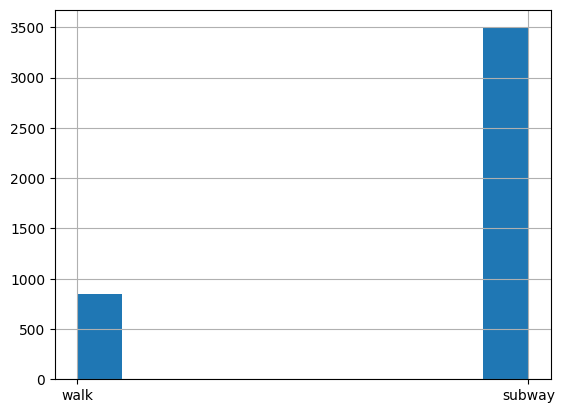

In [44]:
trajectories.df['label'].hist()

In [45]:
def plot_trajectory(
    df: pd.DataFrame,
    ) -> px.scatter_mapbox:
    df['text'] = df['datetime'].dt.strftime('%H:%M')
    fig = px.scatter_mapbox(
        df, 
        lat="latitude", 
        lon="longitude", 
        hover_data=df.columns,
        color='trajectory_id',
        zoom=10,
        template="plotly_dark",
        text='text',
        )
    fig.update_layout(
        margin={"r":0,"t":0,"l":0,"b":0},
        mapbox_style='carto-darkmatter',
        )
    return fig

In [46]:
plot_trajectory(trajectories.df)